In [1]:
"""
Weather Prediction Linear Regression Model

Data: RDU Airport hourly weather data (2015-2025)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')


In [4]:

# Load the preprocessed weather data
df = pd.read_csv('Data_Cleaned/cleaned_weather_final.csv')
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")


Dataset loaded: 94247 rows, 9 columns


In [6]:

# FEATURE ENGINEERING
df_features = df.copy()
df_features['datetime'] = pd.to_datetime(df_features['datetime'])

# Extract cyclical time features
# Why cyclical? Hour 23 and hour 0 are close in time but far numerically
# Sin/cos encoding captures this circular relationship
df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
df_features['day_of_year'] = df_features['datetime'].dt.dayofyear
df_features['day_sin'] = np.sin(2 * np.pi * df_features['day_of_year'] / 365)
df_features['day_cos'] = np.cos(2 * np.pi * df_features['day_of_year'] / 365)
df_features['day_of_week'] = df_features['datetime'].dt.dayofweek

# Create lag features - previous temperature values
# These capture recent temperature trends
df_features['temp_lag_1h'] = df_features['temp'].shift(1)
df_features['temp_lag_3h'] = df_features['temp'].shift(3)
df_features['temp_lag_6h'] = df_features['temp'].shift(6)
df_features['temp_lag_24h'] = df_features['temp'].shift(24)

# Rolling statistics - average temperature over recent windows
# Captures short-term and medium-term trends
df_features['temp_rolling_mean_6h'] = df_features['temp'].rolling(
    window=6, min_periods=1).mean()
df_features['temp_rolling_std_6h'] = df_features['temp'].rolling(
    window=6, min_periods=1).std()
df_features['temp_rolling_mean_24h'] = df_features['temp'].rolling(
    window=24, min_periods=1).mean()

# Remove rows with missing values created by lag features
df_features = df_features.dropna()
print(f"After feature engineering: {df_features.shape[0]} rows, {df_features.shape[1]} columns")

After feature engineering: 94223 rows, 22 columns


In [8]:


# RAIN/VALIDATION SPLIT (NO DATA LEAKAGE)
# Temporal split: all data before Sept 17, 2025 for training
# Sept 17-30, 2025 for final validation
validation_start = '2025-09-17'
validation_end = '2025-10-01'

train_df = df_features[df_features['datetime'] < validation_start]
val_df = df_features[(df_features['datetime'] >= validation_start) &
                      (df_features['datetime'] < validation_end)]

# Define feature columns for model
feature_columns = [
    'hour', 'day_of_year', 'month', 'day_of_week',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'temp_lag_1h', 'temp_lag_3h', 'temp_lag_6h', 'temp_lag_24h',
    'temp_rolling_mean_6h', 'temp_rolling_std_6h', 'temp_rolling_mean_24h'
]

X_train = train_df[feature_columns]
y_train = train_df['temp']

# Synthetic Data

df = df_features.copy()
df["year"] = df["datetime"].dt.year
df["month_day"] = df["datetime"].dt.strftime("%m-%d")

# Filter to past 10 years of the same Sept 17–30 range
hist_df = df[
    (df["year"].between(2015, 2024)) &
    (df["month_day"] >= "09-17") &
    (df["month_day"] <= "09-30")
]

# Compute mean per (month, day, hour) for all features including the target
mean_df = (
    hist_df.groupby(["month", "day", "hour"], as_index=False)
    [feature_columns + ['temp']]
    .mean(numeric_only=True)
)

# Align these means with actual 2025 validation datetimes
synth_df = val_df.copy()
synth_df = pd.merge(
    val_df[["datetime", "month", "day", "hour"]],
    mean_df,
    on=["month", "day", "hour"],
    how="left"
)

X_val = synth_df[feature_columns]
y_val = val_df['temp']

print(f"\nTraining set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Features used: {len(feature_columns)}")


Training set: 93862 samples
Validation set: 336 samples
Features used: 15


In [9]:


# K-FOLD CROSS-VALIDATION ON TRAINING DATA
# Use 5-fold CV to assess model stability and prevent overfitting
# This splits training data into 5 parts, trains on 4, validates on 1
# Repeats 5 times so each part serves as validation once
kfold = KFold(n_splits=5, shuffle=False)  # No shuffle to preserve time order
cv_scores = []

print("\nK-Fold Cross-Validation Results:")
print("-" * 50)

for fold, (train_idx, test_idx) in enumerate(kfold.split(X_train), 1):
    X_fold_train, X_fold_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_fold_train, y_fold_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model = LinearRegression()
    model.fit(X_fold_train, y_fold_train)
    y_pred = model.predict(X_fold_test)

    mse = mean_squared_error(y_fold_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_fold_test, y_pred)
    r2 = r2_score(y_fold_test, y_pred)

    cv_scores.append({'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2})
    print(f"Fold {fold}: MSE={mse:.3f}, RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}")

# Calculate average scores across all folds
avg_cv_mse = np.mean([s['MSE'] for s in cv_scores])
avg_cv_rmse = np.mean([s['RMSE'] for s in cv_scores])
avg_cv_mae = np.mean([s['MAE'] for s in cv_scores])
avg_cv_r2 = np.mean([s['R2'] for s in cv_scores])

print("-" * 50)
print(f"Average CV Scores:")
print(f"  MSE:  {avg_cv_mse:.3f}")
print(f"  RMSE: {avg_cv_rmse:.3f} °C")
print(f"  MAE:  {avg_cv_mae:.3f} °C")
print(f"  R²:   {avg_cv_r2:.3f}")


K-Fold Cross-Validation Results:
--------------------------------------------------
Fold 1: MSE=0.688, RMSE=0.829, MAE=0.615, R²=0.992
Fold 2: MSE=0.685, RMSE=0.828, MAE=0.614, R²=0.992
Fold 3: MSE=0.740, RMSE=0.860, MAE=0.629, R²=0.991
Fold 4: MSE=0.742, RMSE=0.862, MAE=0.636, R²=0.991
Fold 5: MSE=0.709, RMSE=0.842, MAE=0.621, R²=0.991
--------------------------------------------------
Average CV Scores:
  MSE:  0.713
  RMSE: 0.844 °C
  MAE:  0.623 °C
  R²:   0.991


In [10]:


# TRAIN FINAL MODEL ON ALL TRAINING DATA
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Get feature importance
coef_df = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(f"\nTop 5 Important Features:")
print(coef_df.head(5).to_string(index=False))


Top 5 Important Features:
             Feature  Coefficient
temp_rolling_mean_6h     1.809641
         temp_lag_3h    -0.974953
            hour_sin    -0.425371
         temp_lag_1h     0.382356
            hour_cos    -0.332068


In [11]:


# FINAL VALIDATION PERFORMANCE
y_pred_val = lr_model.predict(X_val)

val_mse = mean_squared_error(y_val, y_pred_val)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

print(f"\nFinal Validation Performance (Sept 17-30, 2025):")
print(f"  MSE:  {val_mse:.3f}")
print(f"  RMSE: {val_rmse:.3f} °C")
print(f"  MAE:  {val_mae:.3f} °C")
print(f"  R²:   {val_r2:.3f}")


Final Validation Performance (Sept 17-30, 2025):
  MSE:  13.103
  RMSE: 3.620 °C
  MAE:  2.881 °C
  R²:   0.319


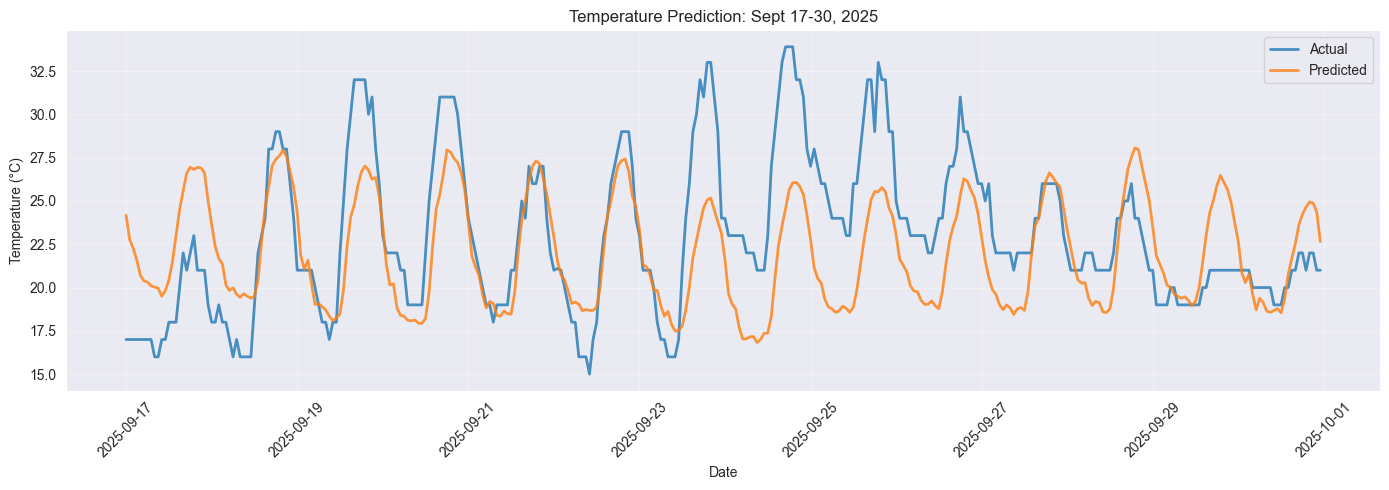

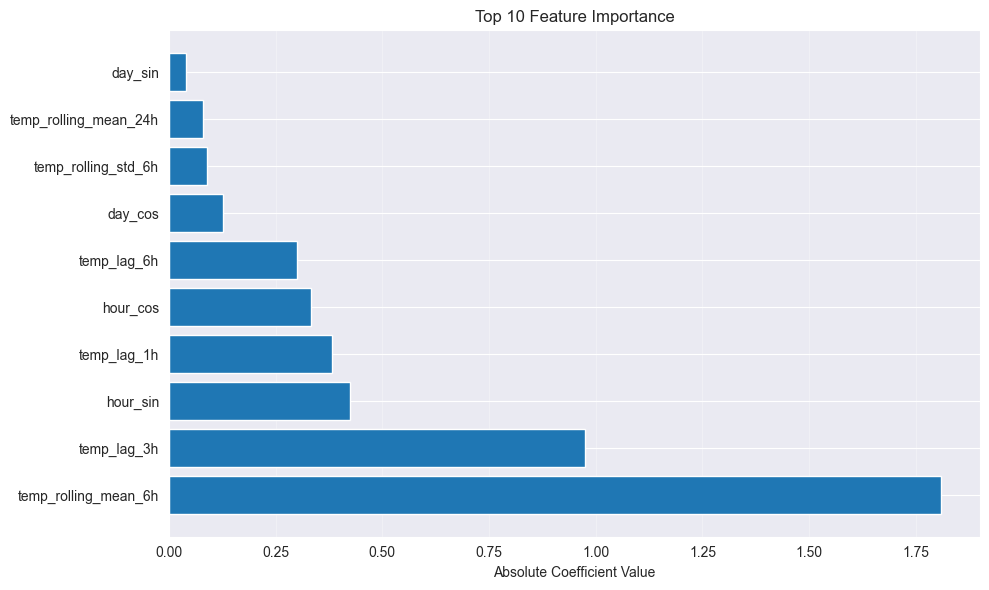

In [12]:


# VISUALIZATION
# Plot 1: Actual vs Predicted over time
plt.figure(figsize=(14, 5))
plt.plot(val_df['datetime'].values, y_val.values,
         label='Actual', linewidth=2, alpha=0.8)
plt.plot(val_df['datetime'].values, y_pred_val,
         label='Predicted', linewidth=2, alpha=0.8)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Prediction: Sept 17-30, 2025')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('predictions_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Feature importance
plt.figure(figsize=(10, 6))
top_features = coef_df.head(10)
plt.barh(range(len(top_features)), top_features['Coefficient'].abs())
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 10 Feature Importance')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:


# Save predictions
predictions_df = pd.DataFrame({
    'datetime': val_df['datetime'].values,
    'actual_temperature': y_val.values,
    'predicted_temperature': y_pred_val,
    'error': y_val.values - y_pred_val
})
predictions_df.to_csv('linear_model_predictions.csv', index=False)

# Save model summary
with open('Old_files/model_summary.txt', 'w') as f:
    f.write("Linear Regression Model - Weather Prediction\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Cross-Validation (5-fold):\n")
    f.write(f"  Average MSE:  {avg_cv_mse:.3f}\n")
    f.write(f"  Average RMSE: {avg_cv_rmse:.3f} °C\n")
    f.write(f"  Average MAE:  {avg_cv_mae:.3f} °C\n")
    f.write(f"  Average R²:   {avg_cv_r2:.3f}\n\n")
    f.write(f"Final Validation Performance:\n")
    f.write(f"  MSE:  {val_mse:.3f}\n")
    f.write(f"  RMSE: {val_rmse:.3f} °C\n")
    f.write(f"  MAE:  {val_mae:.3f} °C\n")
    f.write(f"  R²:   {val_r2:.3f}\n\n")
    f.write(f"Feature Coefficients:\n")
    f.write(coef_df.to_string(index=False))

print("\nResults saved successfully!")
print("  - linear_model_predictions.csv")
print("  - model_summary.txt")
print("  - predictions_timeseries.png")
print("  - feature_importance.png")


Results saved successfully!
  - linear_model_predictions.csv
  - model_summary.txt
  - predictions_timeseries.png
  - feature_importance.png


In [ ]:
#claude ai was used to write/genrate some portions of the code.